# Visible Watermark Information Classification: Model Selection w/ Keras Tuner

This notebook demonstrates an attempt to use Keras Tuner together with Keras CV and Tensorflow to perform model selection. Due to resource constraints
a manual approach was required, but this can be used as a reference for future projects where more GPU resources may be available.

In [ ]:
import os
import typing

import keras
import keras_cv
import tensorflow as tf
import tqdm
import pandas as pd

import sklearn as sk
import numpy as np
import keras_tuner as kt

# Also possible to use jax or pytorch.
os.environ["KERAS_BACKEND"] = "tensorflow"

# attempt to limit memory consumption on the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# Objects/Information we are trying to detect.
# numerical representation is based on list index.
CLASS_IDS = [
    "contact",  # contact information
    "identifier",  # image identifier
    "logo",  # a company logo
    "notice",  # copyright or other type of notice
]

DATA_DIR = "./visible-watermark-detection-VOC2007.v4i.yolov8/"

BOUNDING_BOX_FORMAT = "xyxy"
BATCH_SIZE = 2 # also limit batch size to help limit memory consumption.

VALUE_RANGE = (0, 255)


class RoboflowYOLOv8Loader:
    """RoboflowYOLOv8Loader is a custom data loader that can be used to load
    datasets that are exported from Roboflow in YOLO v8 format.
    """

    class_mapping: dict
    data_dir: str
    batch_size: int = 8
    anchors: list = []

    def __init__(self, class_list: list, data_dir: str, batch_size: int = 8) -> None:
        """constructor for the custom data loader.
        Args:
            class_mapping (dict): classes and numerical representation.
            data_dir (str): top level data directory assuming structure below.
                ├── test
                │   ├── images
                │   └── labels
                ├── train
                │   ├── images
                │   └── labels
                └── valid
                    ├── images
                    └── labels
        """
        assert len(class_list) > 0, "Class list must be greater than 0."

        self.class_mapping = dict(zip(range(len(class_list)), class_list))
        self.data_dir = data_dir
        self.batch_size = batch_size

    def load_dataset(
        self, name: str | None = None
    ) -> tf.data.Dataset | typing.Tuple[tf.data.Dataset]:
        """load_dataset will load a full dataset or a specific split if desired.

        Args:
            name (str | None, optional): split name (train, valid, test).
                    Defaults to None, which will load all 3.

        Returns:
            tf.data.Dataset | typing.Tuple[tf.data.Dataset]: one or a tuple
                of datasets in the following order (train, valid, test).
        """
        if name:
            return self.__load_dataset(name)
        else:
            # load all 3
            train = self.__load_dataset("train", shuffle=True)
            val = self.__load_dataset("valid")
            test = self.__load_dataset("test")
            return (train, val, test)

    def __load_dataset(self, name: str, shuffle: bool = False) -> tf.data.Dataset:
        """__load_dataset is a private function
        that will load one specific split of a dataset
        given the name. (train, valid, test).

        Args:
            name (str): dataset split name (train, valid, test)

        Returns:
            tf.data.Dataset: the tensorflow dataset.
        """
        # validate inputs
        VALID_NAMES = ["train", "valid", "test"]
        assert name.lower() in VALID_NAMES, "name must be one of: " + str(VALID_NAMES)

        # define image and label paths
        split_path = f"{self.data_dir}/{name.lower()}"
        image_dir = f"{split_path}/images"
        label_path = f"{split_path}/labels"
        image_paths = sorted(
            [
                os.path.join(image_dir, f)
                for f in os.listdir(image_dir)
                if f.endswith(".jpg")
            ]
        )
        label_paths = sorted(
            [
                os.path.join(label_path, f)
                for f in os.listdir(label_path)
                if f.endswith(".txt")
            ]
        )

        # load images and data using yolo v8 labels.
        bbox = []
        classes = []
        for label in tqdm.tqdm(label_paths):
            boxes, class_ids = RoboflowYOLOv8Loader.parse_yolo_label(label)
            bbox.append(boxes)
            classes.append(class_ids)

        assert (
            len(image_paths) == len(bbox) == len(classes)
        ), "inputs must be the same length on the first dimension."

        # can contain lists of varying lengths, so its recommended to use ragged tensors.
        bbox = tf.ragged.constant(bbox)
        classes = tf.ragged.constant(classes)
        image_paths = tf.ragged.constant(image_paths)

        # load into tf dataset and process into standard structure.
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
        dataset = dataset.map(
            RoboflowYOLOv8Loader.to_dataset_dict, num_parallel_calls=tf.data.AUTOTUNE
        )
        return dataset

    @staticmethod
    def load_image(image_path: str) -> tf.Tensor:
        """the image in tensor format"""
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize_with_pad(image, 640, 640)
        return image

    @staticmethod
    def to_dataset_dict(
        image_path: str, classes: tf.RaggedTensor, bbox: tf.RaggedTensor
    ) -> dict:
        """data loaded in standard pipeline format:
        {
            "images": Tensor(),
            "bounding_boxes": {
                "classes": Tensor(),
                "boxes": RaggedTensor()
            }
        }
        Reference: https://keras.io/examples/vision/yolov8/

        Args:
            image_path (str): path to image
            classes (tf.RaggedTensor): classes in the image
            bbox (tf.RaggedTensor): bounding boxes in the image

        Returns:
            dict: standard tf pipeline format
        """
        image = RoboflowYOLOv8Loader.load_image(image_path)
        bounding_boxes = {
            "classes": tf.cast(classes, dtype=tf.float32),
            "boxes": bbox,
        }
        return {"images": image, "bounding_boxes": bounding_boxes}

    @staticmethod
    def parse_yolo_label(
        label_path: str, image_width: int = 640, image_height: int = 640
    ) -> typing.Tuple[list]:
        """parse_yolo_label will read an input txt file in the yolov8 format
        (center_xywh) and return it in xmin, ymin, xmax, ymax (Pascal VOC format).

        Args:
            label_path (str): path to label file.
            image_width (int, optional). Defaults to 640.
            image_height (int, optional). Defaults to 640.

        Returns:
            typing.Tuple[list]: boxes, class_ids
        """
        with open(label_path, "r") as f:
            lines = f.readlines()

        boxes = []
        class_ids = []

        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])

            # YOLOv8 bounding box in [x_center, y_center, width, height]
            x_center, y_center, width, height = parts[1:]

            # Convert center_xywh to xmin, ymin, xmax, ymax (Pascal VOC format)
            xmin = (float(x_center) - float(width) / 2) * image_width
            ymin = (float(y_center) - float(height) / 2) * image_height
            xmax = (float(x_center) + float(width) / 2) * image_width
            ymax = (float(y_center) + float(height) / 2) * image_height

            boxes.append([xmin, ymin, xmax, ymax])
            class_ids.append(class_id)
            RoboflowYOLOv8Loader.anchors.append([width, height])

        return boxes, class_ids


def visualize_dataset(inputs, class_mapping, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale = 6,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color = (192, 57, 43))

2025-02-12 16:47:53.237116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739396873.347833    2419 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739396873.391616    2419 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 16:47:53.642276: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/gb/FinalProject/iteration3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please

## Load the visual watermark detection data

The `RoboflowYOLOv8Loader` is then used to load and split the data into different sets required in the pipeline.

In [2]:
# construct custom dataset loader.
data_loader = RoboflowYOLOv8Loader(CLASS_IDS, DATA_DIR, batch_size=BATCH_SIZE)

# load dataset.
# split percentage is managed by Roboflow and exported.
train, val, test = data_loader.load_dataset()

100%|██████████| 72/72 [00:00<00:00, 2588.99it/s]
I0000 00:00:1739396880.036814    2419 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6061 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
100%|██████████| 10/10 [00:00<00:00, 4567.47it/s]


## Data Pre-Processing and Augmentation

Below is the same example of using augmentation for the dataset, shuffling and batching before fine tuning the model.

In [3]:
augmenters = [
    keras_cv.layers.RandomSaturation(factor=0.1),
    keras_cv.layers.RandomBrightness(factor=0.1),
    keras_cv.layers.RandomContrast(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.RandomHue(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640),
        scale_factor=(0.8, 1.2),
        bounding_box_format=BOUNDING_BOX_FORMAT
    )
]   

def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn

augmenter_fn = create_augmenter_fn(augmenters)


resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format=BOUNDING_BOX_FORMAT, pad_to_aspect_ratio=True
)

def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=30
    )

# load into correct format for the model
train_ds = ( train
                .shuffle(BATCH_SIZE * len(CLASS_IDS))
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

val_ds =   ( val
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

test_ds =  ( test
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

TRAINING DATA


2025-02-12 16:48:04.591248: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node jittered_resize_1/stateful_uniform/Cast_1/_4}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-02-12 16:48:04.592933: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16894960513895410164
2025-02-12 16:48:04.593365: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18072471571526771285
2025-02-12 16:48:04.594244: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node jittered_resize_1/stateful_uniform/Cast_1/_4}}]]
	 [[jittered_resize_1/stateful_uniform/Cast_1/_3]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-02-12 16:48:04.741224: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting wit

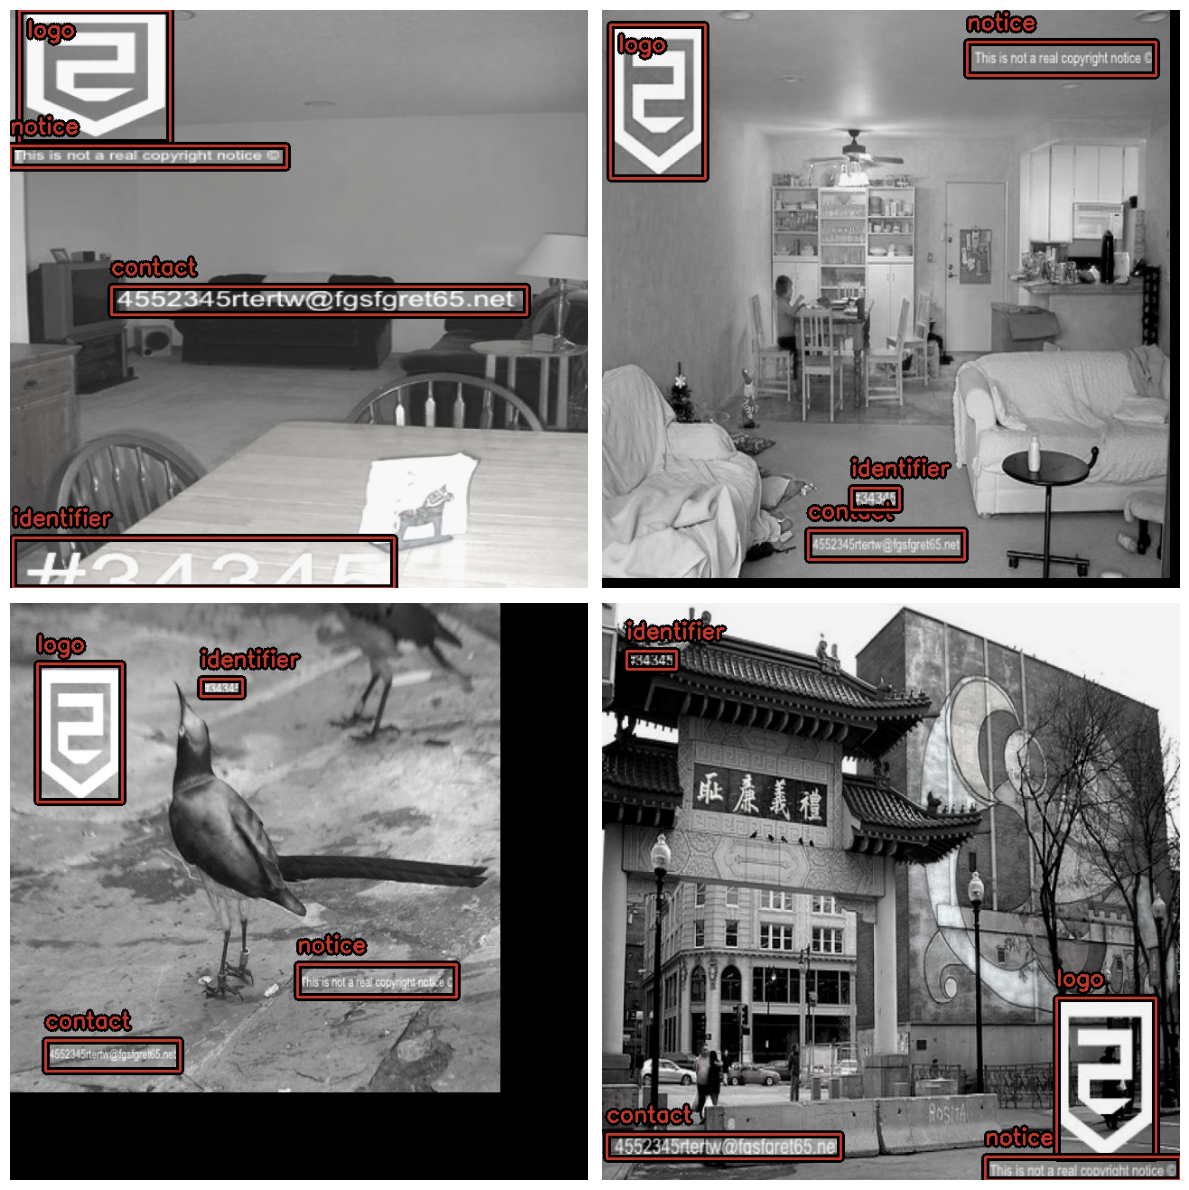

In [4]:
# visualize the training split.
print("TRAINING DATA")
visualize_dataset(
    train_ds,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT, 
    value_range=(0, 255), rows=2, cols=2, 
)

VALIDATION DATA


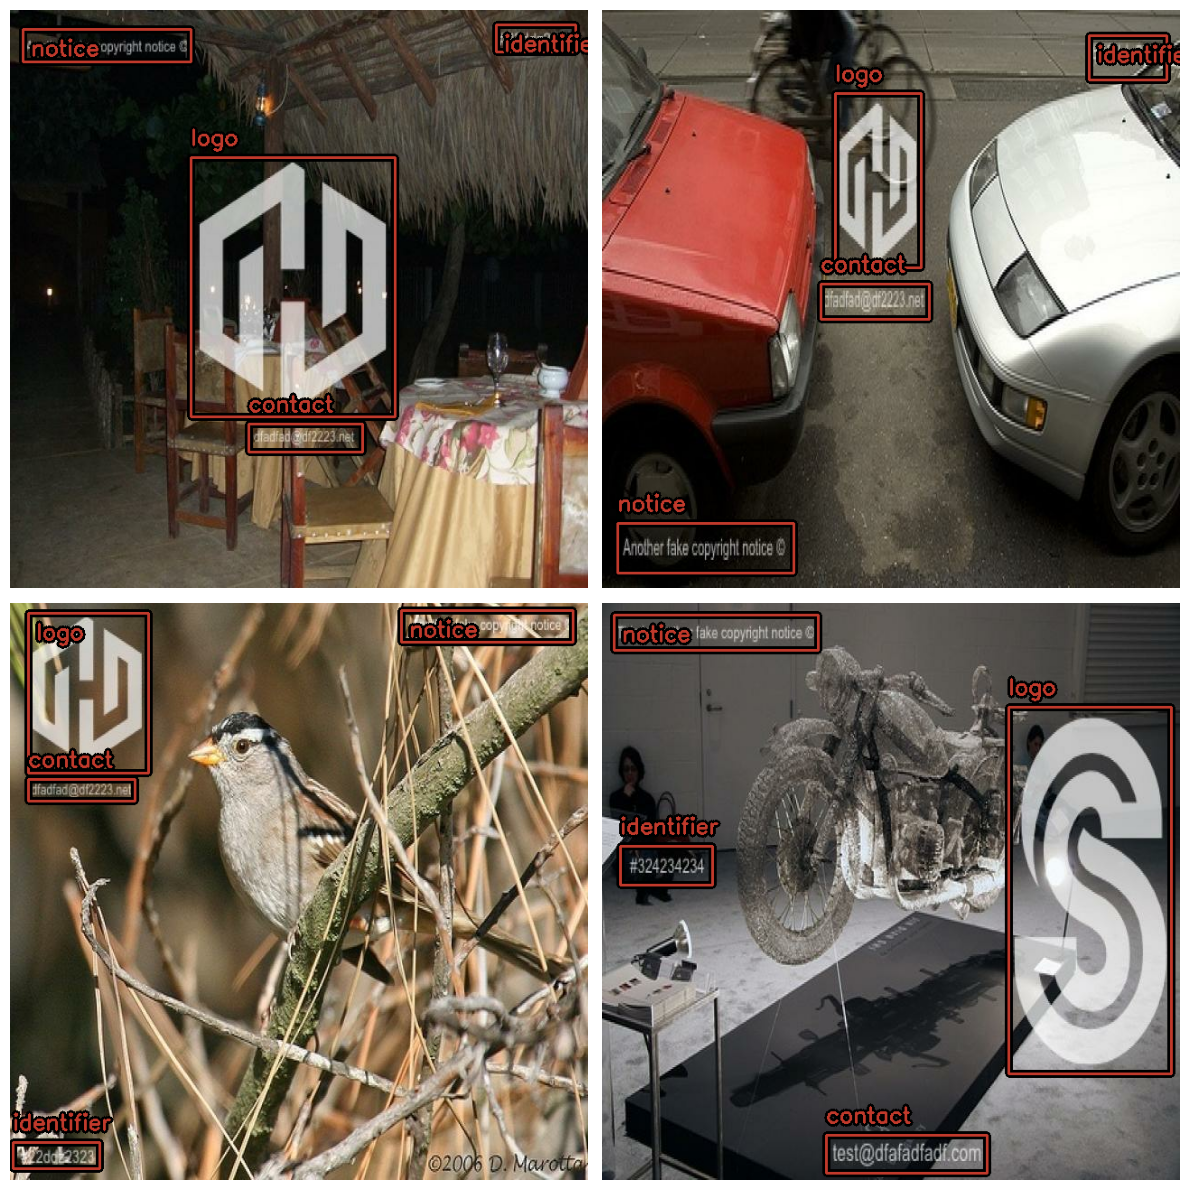

In [5]:
print("VALIDATION DATA")
visualize_dataset(
    val_ds,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    value_range=(0, 255),
    rows=2,
    cols=2,
)

# Yolo V8 Hyper Model

The hypermodel is what is used to define the search space to use for model selection and hyper parameter tuning/optimization. 

In the example below, I select different model architectures (backbones, optimizers, loss functions etc.) as well as their associated hyperparameters.

Defining the model and the choices to be taken defines the search space that will be used to selection/optimization.

In [ ]:
class YOLOV8DetectorHyperModel(kt.HyperModel):

    def build(self, hp: kt.HyperParameters) -> keras_cv.models.YOLOV8Detector:
        '''build_model uses the HyperParameters class to define
        the search space for model selection using KerasTuner.

        Args:
            hp (kt.HyperParameters): hyper parameters object for searching.

        Returns:
            keras.Sequential: the Sequential model to use for searching.
        '''

        fpn_depth = hp.Choice("fpn_depth", [1, 2, 3])

        prediction_decoder=keras_cv.layers.NonMaxSuppression(
            bounding_box_format=BOUNDING_BOX_FORMAT,
            from_logits=hp.Choice("from_logits", [True, False]),
            confidence_threshold=hp.Choice("confidence_threshold", [0.4, 0.5, 0.75, 0.90]),
            iou_threshold=hp.Choice("iou_threshold", [0.1, 0.4, 0.5, 0.75])
        )

        backbone = hp.Choice(
            "backbone",
            [
                "yolo_v8_xs_backbone_coco",
                "yolo_v8_s_backbone_coco",
            ],
        )

        model = keras_cv.models.YOLOV8Detector(
            backbone=keras_cv.models.YOLOV8Backbone.from_preset(backbone, load_weights=True),
            num_classes=len(CLASS_IDS),
            fpn_depth=fpn_depth,
            prediction_decoder=prediction_decoder,
            bounding_box_format=BOUNDING_BOX_FORMAT,
        )

        # Classification loss settings
        classification_loss_mapping = {
            "categorical_crossentropy": keras.losses.CategoricalCrossentropy(),
            "categorical_focal_crossentropy": keras.losses.CategoricalFocalCrossentropy(),
        }

        classification_loss = hp.Choice(
            "classification_loss",
            [   
                "categorical_crossentropy",
                "categorical_focal_crossentropy"
            ],
        )

        # Optimizer settings
        initial_learning_rate = 0.01
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate,
            decay_steps=1000,
            alpha=0.0
        )

        global_clipnorm = hp.Choice("global_clipnorm", [8.0, 9.0, 10.0])
        weight_decay = hp.Choice("weight_decay", [1e-4, 1e-5, 1e-6])
        momentum = hp.Choice("momentum", [0.7, 0.85, 0.95])

        optimizer_mapping = {
            "adam": keras.optimizers.Adam(
                learning_rate=lr_schedule,
                global_clipnorm=global_clipnorm,
                weight_decay=weight_decay
            ),
            "rmsprop": keras.optimizers.RMSprop(
                learning_rate=lr_schedule,
                global_clipnorm=global_clipnorm,
                weight_decay=weight_decay,
                momentum=momentum
            ),
            "sgd": keras.optimizers.SGD(  
                learning_rate=lr_schedule,
                global_clipnorm=global_clipnorm,
                weight_decay=weight_decay,
                momentum=momentum 
            ),
        }

        optimizer = hp.Choice(
            "optimizer", [
                "adam", "rmsprop", "sgd"
            ],
        )

        # box loss settings
        box_loss_mapping = {
            "ciou": keras_cv.losses.CIoULoss(bounding_box_format=BOUNDING_BOX_FORMAT),
            "giou": keras_cv.losses.GIoULoss(bounding_box_format=BOUNDING_BOX_FORMAT),
        }

        box_loss = hp.Choice(
            "box_loss", [
                "ciou", "giou"
            ],
        )


        # compile with selections
        model.compile(
            classification_loss=classification_loss_mapping[classification_loss],
            box_loss=box_loss_mapping[box_loss],
            optimizer=optimizer_mapping[optimizer],
        )

        return model

# Using RandomSearch is a good starting point for projects with limited time / resources
# as it will randomly select values from the search space.  For more systematic search,
# the GridSearch can be used to search all possible combinations.
tuner = kt.RandomSearch(
    hypermodel=YOLOV8DetectorHyperModel(),
    objective="val_loss",           # Unable to use PyCOCO metrics as objective due to copy issue. :(
    max_trials=15,  # search at most 25 different sets of hyperparameters.
    executions_per_trial=2, # train 2 times per set of hyperparams.
    overwrite=True,
    directory="./model_selection/random_search",
    project_name="yolov8",
)

# show search space based on hyperparameter combinations we are testing.
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 11
fpn_depth (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
from_logits (Choice)
{'default': 1, 'conditions': [], 'values': [1, 0], 'ordered': True}
confidence_threshold (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.4, 0.5, 0.75, 0.9], 'ordered': True}
iou_threshold (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.4, 0.5, 0.75], 'ordered': True}
backbone (Choice)
{'default': 'yolo_v8_xs_backbone_coco', 'conditions': [], 'values': ['yolo_v8_xs_backbone_coco', 'yolo_v8_s_backbone_coco'], 'ordered': False}
classification_loss (Choice)
{'default': 'categorical_crossentropy', 'conditions': [], 'values': ['categorical_crossentropy', 'categorical_focal_crossentropy'], 'ordered': False}
global_clipnorm (Choice)
{'default': 8.0, 'conditions': [], 'values': [8.0, 9.0, 10.0], 'ordered': True}
weight_decay (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 1e-05, 1e-06], 'ordered

In [ ]:
# perform random search over the hyperparameter search space.
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=50,    # set max number of epochs, will be stopped by EarlyStopping callback.
    callbacks=[
        keras.callbacks.TensorBoard(log_dir="./model_selection/training_logs"),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,  # Stop after 5 epochs if no improvement
            verbose=0,
        ),
    ],
    verbose=0,
)

# # view summary of top 3 trials. Restricted to limit report length.
tuner.results_summary(num_trials=3)

top_models = tuner.get_best_models(num_models=5)
top_hyperparameters = tuner.get_best_hyperparameters(num_trials=5)

top_model = top_models[0].build(top_hyperparameters[0])

top_model.summary()

/home/gb/FinalProject/iteration3/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)
I0000 00:00:1739396918.784421    2497 service.cc:148] XLA service 0x7f3c500020b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739396918.790193    2497 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2025-02-12 16:48:40.848452: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739396923.623047    2497 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-12 16:48:47.333472: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.30GiB 

# References

[1] Team, Keras. “Keras Documentation: Efficient Object Detection with YOLOV8 and KerasCV.” Keras.io, keras.io/examples/vision/yolov8/.

[2] K. Team, “Keras documentation: Keras API reference” Keras.io. https://keras.io/api/

[3] K. Team, "Keras Tuner: Getting Started" Keras.io. https://keras.io/keras_tuner/getting_started/
‌